Import the necessary libaries. 

- NumPy is used for logarithmic and exponential transformations.
- Yfinance is used to obtain the stock data.
- Pandas (if you choose not to use yfinance) is used to read the CSV data containing stock information.
- Sklearn (Sckit-learn) is used to obtain the Machine Learning model.
- And Matplotlib is used for data visualisation.
- Ensure these are all installed using the command "pip install numpy yfinance pandas sckit-learn matplotlib" into your terminal if you haven't done so already.

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt

The code below demonstrates the conditions and parameters of choice. Here, I am visualising data between December 2019 and December 2024 for the S&P 500 Index Fund. This is the most relevant data at the time of writing. This is demonstrated using the ticker symbol available on yfinance as "^GSPC". We want our data to have an interval of one day, hence why it is an argument called within the download function.

In [2]:
ticker_symbol = "^GSPC"
start_date = "2019-12-01"
end_date = "2024-12-01"
data = yf.download(tickers=ticker_symbol, start=start_date, end=end_date, interval="1d")

[*********************100%***********************]  1 of 1 completed


Here is the code to calculate our returns. We firstly need to ensure the closing data is extracted from yfinance and that we resample this to ensure it is using daily intervals for our calculations.

The formula we are essentially using here is:
$R_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$

Where:
- $R_t$ = Logarithmic daily return at time $t$
- $P_t$ = Stock price at time $t$
- $P_{t-1}$ = Stock price at time $t-1$ (shifted by 1 day)

We need daily returns later on for our predictions in the Machine Learning Model :)

In [3]:
data["Daily_Sample"] = data[( 'Close', '^GSPC')].resample("D").last()
data["Daily_Returns"] = np.log(data["Daily_Sample"]/data["Daily_Sample"].shift(1))
data.dropna(inplace=True) 

Then, we are going to start determining how we want our Machine Learning model to operate. 

Firstly, we must create a list of lags that the model will end up using to predict. I am going with 3 lags as although 2 lags is more ideal, it fails to produce two seperate lines for effective interpretation. 

Too many lags can encourage overfitting - this is when the Machine Learning model is trained too heavily with past data, accounting for noise and very specific changes, preventing useful future predictions as it is too accustomed to the data it is trained with.

A way that we can determine an ideal number of lags is by using the ACF plot and looking at the lines far outside the confidence interval - this shows where autocorrelation is most significant in the data. Significant lags have a meaningful relationship with the present, so including them in the ML model will be useful and help to generate reliable predictions. Any lags that produce lines well within the confidence interval are likely noise, and their inclusion would result in overfitting. The ACF plot is visualised below, with the relevant code found in the Time Series repository.

[ACF Plot](https://github.com/oaerobert/Python-for-Finance/blob/48707130ec24222bcb12a5097401a82eae6e8d85/ML%20Predictive%20Model/ACF%20Plot.png)

Hence, the code shows a loop with the appropriate number of lags +1, creating a variable name for each lag when is appended in the columns list. Any missing values created from the shifts are dropped.

In [9]:
lags = 3
columns =[]

for lag in range(1, lags+1):
    col = f"lag{lag}"
    data[col] = np.sign(data["Daily_Returns"].shift(lag))
    columns.append(col)
data.dropna(inplace=True)

Next, we can officially do I what I call the three components. Fit, Predict and Strategise. 

We define the model according to it's name, which is SVC, gamma =auto.
Then, we fit the model to the appended list we just created, keeping the target variable (the signs of daily returns) in mind. 
(Our x argument is what we actually use to fit, then our y argument is what we are essentially saying "hey, we want you to actually look like this.")

We then create a prediction of data based on past lags, and determine if our strategy is effective by multiplying our prediction by our daily returns.

In [10]:
model = SVC(gamma="auto")
model.fit(data[columns], np.sign(data["Daily_Returns"]))
data["Prediction"] = model.predict(data[columns])
data["Strategy"] = data["Prediction"] * data["Daily_Returns"]

Here we are simply defining the aesthetics of our code. These are variable and can be changed within Matplotlib.

In [11]:
plt.style.use("seaborn-v0_8-paper")
plt.rc("font", family="serif")

Next, we create some new variables within the DataFrame that correspond to the scatter graph that we are going to create ontop of our line graph to illustrate the points of buying and selling. 

We want our 'buy' variable to be when the model predicts a positive return (essentially the ML is saying, hey, we think its going to go up and its a best time to buy) and our sell to be the opposite.

In [12]:
data["Buy"] = data["Prediction"] == 1
data["Sell"] = data["Prediction"] == -1

This code shows the visualisation of the cumulative sum of our daily returns and the strategy we have created with the ML model. We have defined our colours and axis titles, and also included a scatter plot ontop of the strategy line. This can be visualised to look like the following in Matplotlib.

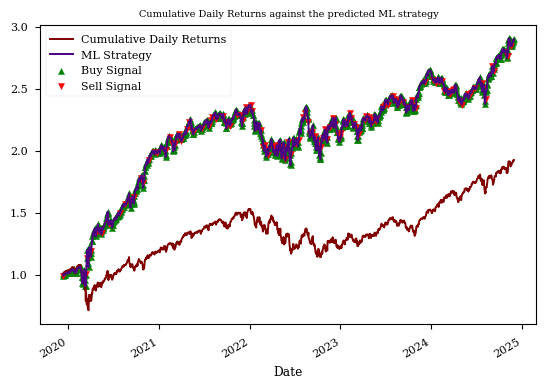

In [13]:
ax = data[["Daily_Returns","Strategy"]].cumsum().apply(np.exp).plot(subplots=False, color=["maroon","indigo"], label= ["Cumulative Daily Returns", "ML Strategy"])

ax.set_title("Cumulative Daily Returns against the predicted ML strategy", fontsize=7)

plt.scatter(data.index[data["Buy"]], data["Strategy"].cumsum().apply(np.exp)[data["Buy"]], label="Buy Signal", marker="^", color="green", alpha=1, s=20)
plt.scatter(data.index[data["Sell"]], data["Strategy"].cumsum().apply(np.exp)[data["Sell"]], label="Sell Signal", marker="v", color="red", alpha=1, s=20)

plt.legend(loc="upper left", labels=["Cumulative Daily Returns", "ML Strategy", "Buy Signal", "Sell Signal"])
plt.show()

[Machine Learning Model](https://github.com/oaerobert/Python-for-Finance/blob/f79171141802f5fbbe2bc9a47b51f851ce01a09c/ML%20Predictive%20Model/ML%20Model%20Visualisation.png)